# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Первая лабораторная работа </center>


В данной работе Вы познакомитесь с основными методами работы с аудиоданными в Python. Разбересь в том, как работает свертка, и примените пару интересных фильтров.

# Задание 1. Работа с аудиофайлами в Python (1 балл)

## Теория

Звук - это аналоговый сигнал. То есть он является непрерывным по времени и по значениям. Для того, чтобы работать со звуком на цифровом устройстве, надо преобразовать его в цифровое представление. Для этого надо разделить непрерывный сигнал на промежутки времени (дискретизация сигнала) и разбить непрерывные значения на интервалы (квантование сигнала). Выбраные параметры дискретизации и квантования сигнала напрямую влияют на качество цифрового сигнала. 


## Практика

1. Что хранится в .wav файле? Как узнать параметры дискретизации и квантования .wav файла? 

2. Запишите аудиофайл со своим голосом. Загрузите его. Попробуйте поменять ему частоту дискретизации. Нарисуйте форму волны считанного файла. Воспроизведите полученные сигналы. При какой частоте дискретизации становится невозможно разобрать человеческую речь?   

3. Чем .wav отличается от других кодеков, например .mp3 или .ogg?


### Подсказка

Записать цифровой сигнал можно при помощи, например, [Audacity](https://www.audacityteam.org) или [Adobe Audition](https://www.adobe.com/ru/products/audition.html). Для считывания файлов воспользуйтесь библиотекой [scipy](https://www.scipy.org) или [librosa](https://librosa.org/doc/latest/index.html). Для воспроизведения аудиофайла удобно использовать класс Audio из модуля IPython.display, а для отрисовки - matplotlib.

In [1]:
import IPython.display as ipd
import matplotlib.pyplot as plt 
import numpy as np
from scipy.io import wavfile
from scipy.signal import convolve
import pyaudio
import time
import wave
%matplotlib inline

**Задача 1.** Что хранится в .wav файле? Как узнать параметры дискретизации и квантования .wav файла?

**Решение.** Установим модуль `pyAudio` для записи голоса прямо в `Jupyter Notebook`. Далее установим параметры дискретизации(`RATE`) и квантования(`FORMAT`) .wav файла.

In [ ]:
!pip install PyAudio

In [ ]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
SECONDS = 10.0
SOUND_PATH = 'output.wav'

def record():

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("Start recording")

    frames = []
    timing = time.time()
    while time.time() - timing <= SECONDS:
        data = stream.read(CHUNK)
        frames.append(data)
        
    print("Done recording")
    
    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

    return sample_width, frames

def record_to_file(file_path):
    wf = wave.open(file_path, 'wb')
    wf.setnchannels(CHANNELS)
    print("Please speak into the microphone")
    sample_width, frames = record()
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    print("Result was written to", file_path)
    
record_to_file('resources/speech.wav')

**Задание 2.** Запишите аудиофайл со своим голосом. Загрузите его. Попробуйте поменять ему частоту дискретизации. Нарисуйте форму волны считанного файла. Воспроизведите полученные сигналы. При какой частоте дискретизации становится невозможно разобрать человеческую речь?

**Решение.** Файл был записан и загружен в `resources/speech.wav`. 

In [ ]:
ipd.Audio('resources/speech.wav')

In [ ]:
fz, data = wavfile.read('resources/speech.wav')
plt.plot(data, label='wave form');
plt.xlabel('n samples');
plt.ylabel('amplitude');
plt.legend();

Попробуем уменьшить частоту в 4 раза.

In [ ]:
decrease_up = 4
wavfile.write('resources/speech_4.wav', int(RATE/decrease_up), data[0::decrease_up])

In [ ]:
ipd.Audio('resources/speech_4.wav')

Попробуем уменьшить частоту в 16 раз.

In [ ]:
decrease_up = 16
wavfile.write('resources/speech_16.wav', int(RATE/decrease_up), data[0::decrease_up])

In [ ]:
ipd.Audio('resources/speech_16.wav')

Попробуем уменьшить частоту в 32 раза.

In [ ]:
decrease_up = 32
wavfile.write('resources/speech_32.wav', int(RATE/decrease_up), data[0::decrease_up])

In [ ]:
ipd.Audio('resources/speech_32.wav')

In [ ]:
Экстраполируя, получается, что если уменьшить частоту в 64 раза, слабо можно что-либо разобрать

# Задание 2. Гармонические сигналы (1 балл)

## Теория
[Гармонические колебания](https://ru.wikipedia.org/wiki/Гармонические_колебания) -  колебания, при которых физическая величина изменяется с течением времени по гармоническому (синусоидальному/косинусоидальному) закону. 

В общем случае гармонические колебания задаются формулой:

$$y=A \cos(\omega t+\varphi_0)$$

где $А$ - это амплитуда, $\omega$ – циклическая частота (радиан/с), $\varphi$ - фаза (сдвиг), $t$ – время. 


In [ ]:
# Сначала определим функцию для отрисовки сигнала с хорошим масштабом и сеткой
# Это поможет легче анализировать сигнал
def draw_signal(data, figsize=(14, 14)):
    plt.figure(figsize=figsize)
    plt.plot(data, linewidth=2)
    plt.minorticks_on()
    plt.xticks(np.arange(0, 1000, step=100))
    plt.yticks(np.arange((data.min().round())//10*10, 
                         (data.max().round())//10*10+10, step=5))
    plt.grid(which='major',
        color = 'k', 
        linewidth = 1)
    plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
    plt.show()

In [ ]:
# Читаем данные с подготовленными сигналами
import pickle
with open("resources/data.pickle", "rb") as f:
    test_data = pickle.load(f)
# Теперь можно приступать к практике!

## Практика

Постройте графики трех сигналов a, b и c из test_data['task2']. Попробуйте подобрать коэффициенты для этих сигналов. Сгенерируйте сигналы (1000 отсчетов) с подобранными коэффициентами. Постройте графики сгенерированных сигналов и пройдите тест на схожесть с оригинальным.


Подсказка. Фаза, период и амплитуда сигнала - целочисленные. Для генерации пользуйтесь библиотекой numpy и функциями arange, sin, cos.

In [ ]:
t = np.arange(0, 1000, 1)

In [ ]:
draw_signal(test_data['task2']['a'])

In [ ]:
# YOUR CODE HERE
A = 45
fi = 0
T = 425
w = 2*np.pi/T
a = A*np.cos(w*t + fi)

In [ ]:
draw_signal(a)

In [ ]:
assert len(a) == 1000
assert np.allclose(a, test_data["task2"]["a"], atol=1)
print("Ok!")

In [ ]:
draw_signal(test_data['task2']['b'])

In [ ]:
# YOUR CODE HERE
A = 50
fi = -np.pi/2
T = 100
w = 2*np.pi/T
b = A*np.cos(w*t + fi)

In [ ]:
assert len(b)== 1000
assert np.allclose(b, test_data["task2"]["b"], atol=1)
print("Ok!")

In [ ]:
draw_signal(test_data['task2']['c'])

In [ ]:
# сигнал состоит из двух гармоник
# YOUR CODE HERE

c = a - b

In [ ]:
assert len(c)== 1000
assert np.allclose(c, test_data["task2"]["c"], atol=1)
print("Ok!")

# Задание 3. Свертка (3 балла)

## Теория
Одна из наиболее частых операций, которая выполняется при обработке сигналов, это свёртка. Свёртка имеет много различных применений, например, с ее помощью можно убрать из сигнала шумы или применить к сигналу эффект эхо.


Свёртка — это математическая операция, применённая к двум функциям f и g и порождающая третью функцию. Операцию свёртки можно интерпретировать как «схожесть» одной функции с отражённой и сдвинутой копией другой.  Другими словами, преобразование свёртки однозначно определяет выходной сигнал y(t) для установленного значения входного сигнала x(t) при известном значении функции импульсного отклика системы h(t).

![Convolution](resources/Convolution_of_box_signal_with_itself2.gif "Convolution")

Формула свёртки:
$$y_t=\frac{1}{2} \int_0^T x(\tau)h(t-τ)dτ$$
где $\tau$  - длительность импульсной переходной характеристики.

## Практика
Реализуйте операцию свёртки. Сравните её с существующей реализацией scipy.signal.convolve. Постройте графики фильтра, исходного сигнала и результата свертки.

In [44]:
def my_convolve(in1, in2):
    result = np.zeros((len(in1) + len(in2) - 1,))
    for k in range(len(in1)):
        sum_ = 0
        for j in range(len(in1)):
            index = k - j
            if 0 <= index < len(in2):
                sum_ += in1[j] * in2[index]
                
        result[k] = sum_
        
    return result

In [45]:
def test_convolve(a, b, print_debug=False):
    my_result = my_convolve(a, b)
    scipy_result = convolve(a, b, method='direct')
    if print_debug:
        print(f"Your result {my_result}")
        print(f"Scipy result {scipy_result}")
    assert np.allclose(my_result, scipy_result), f"Test {a} conv {b} failed"
    print("Ok!")

In [46]:
a = np.repeat([0,1,0], 10)
b = np.array([0,1,2,3,2,1,0])

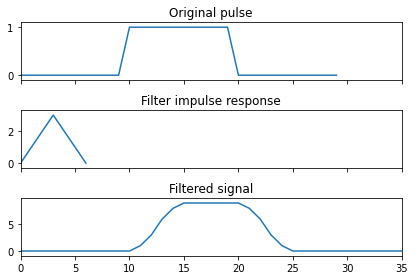

In [50]:
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(a)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(b)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(my_convolve(a, b))
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()

In [48]:
test_convolve(a, b, print_debug=True)

Your result [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 3. 6. 8. 9. 9. 9. 9. 9. 9. 8. 6. 3.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Scipy result [0 0 0 0 0 0 0 0 0 0 0 1 3 6 8 9 9 9 9 9 9 8 6 3 1 0 0 0 0 0 0 0 0 0 0 0]
Ok!


## Задание 4. * Алгоритм Карплуса-Стронга 

Реализуйте  [Алгоритм Карплуса-Стронга](https://en.wikipedia.org/wiki/Karplus%E2%80%93Strong_string_synthesis). В качестве фильтра используйте усреднитель двух смежных отсчетов. Проверьте результат. 

Отрисуйте и воспроизведите полученный сигнал. На что влияют параметры генерации? Попробуйте имитировать звучание разных струн гитары.

In [ ]:
def karplus_strong(noise, N):
    # Noise - input
    # N - number of samples to generate
    # return y - generated signal based on Noise 
    # YOUR CODE HERE
    #
   
    #
    raise NotImplementedError()

In [ ]:
np.random.seed(seed=1)
sample_rate = 44100 
frequency = 82.41
sec = 2
gen_len = sample_rate * sec
noise = (2 * np.random.uniform(-1, 1, int(sample_rate/frequency))) # [-1, 1]

gen_wav = karplus_strong(noise, gen_len)
assert np.allclose(gen_wav[:len(noise)], noise), "Generated signal must starting with noise"
assert np.allclose(gen_wav[len(noise)], (noise[0])/2), "Out of range samples eq 0."
assert np.allclose(gen_wav[len(noise)+1: 2*len(noise)], (noise[:-1] + noise[1:])/2), \
    "Bad requrent rule( 1 iteration)"
assert np.allclose(gen_wav[2*len(noise)], (noise[0]/2 + noise[-1])/2), \
    "Bad requrent rule( 2 iteration)"
assert np.allclose(gen_wav[2*len(noise)+2: 3*len(noise)], \
                   (((noise[:-1] + noise[1:])/2)[:-1] + ((noise[:-1] + noise[1:])/2)[1:])/2), \
    "Bad requrent rule( 3 iteration)"
print('All Ok!')

In [ ]:
# Попробуйте покрутить параметры генерации. 
# YOUR CODE HERE 